In [1]:
# Import Package(s)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy import compute_dp_sgd_privacy_lib

In [2]:
#1.

data_v1 = pd.read_csv("athletes.csv")

data_v1.to_csv("dataset_v1.csv", index=False)

In [3]:
#2.

data_v2 = data_v1.dropna(subset=['region', 'age', 'weight', 'height', 'howlong', 'gender', 'eat',
                                 'train', 'background', 'experience', 'schedule', 'howlong',
                                 'deadlift', 'candj', 'snatch', 'backsq'])

data_v2 = data_v2.drop(columns=['affiliate', 'team', 'name', 'athlete_id', 'fran', 'helen', 'grace',
                                'filthy50', 'fgonebad', 'run400', 'run5k', 'pullups', 'train'])

data_v2 = data_v2[data_v2['weight'] < 1500]
data_v2 = data_v2[data_v2['gender'] != '--']
data_v2 = data_v2[data_v2['age'] >= 18]
data_v2 = data_v2[(data_v2['height'] < 96) & (data_v2['height'] > 48)]
data_v2 = data_v2[(data_v2['deadlift'] > 0) & ((data_v2['deadlift'] <= 1105) |
                ((data_v2['gender'] == 'Female') & (data_v2['deadlift'] <= 636)))]
data_v2 = data_v2[(data_v2['candj'] > 0) & (data_v2['candj'] <= 395)]
data_v2 = data_v2[(data_v2['snatch'] > 0) & (data_v2['snatch'] <= 496)]
data_v2 = data_v2[(data_v2['backsq'] > 0) & (data_v2['backsq'] <= 1069)]

decline_dict = {'Decline to answer': np.nan}
data_v2 = data_v2.replace(decline_dict)
data_v2 = data_v2.dropna(subset=['background', 'experience', 'schedule', 'howlong', 'eat'])

data_v2.to_csv("dataset_v2.csv", index=False)

In [4]:
#3.

data_v1["total_lift"] = data_v1["deadlift"] + data_v1["candj"] + data_v1["snatch"] + data_v1["backsq"]

train_v1, test_v1 = train_test_split(data_v1, test_size=0.2, random_state=42)

data_v2["total_lift"] = data_v2["deadlift"] + data_v2["candj"] + data_v2["snatch"] + data_v2["backsq"]

train_v2, test_v2 = train_test_split(data_v2, test_size=0.2, random_state=42)

4-1. First, I used LakeFS as stated in the question. I made sure Docker Desktop was running, and ran 'docker run --name lakefs --pull always --rm --publish 8000:8000 treeverse/lakefs:latest run --quickstart'. Then I navigated to 'http://127.0.0.1:8000/repositories/mlops-assignment1/objects?path=&ref=main'on browser. Screenshot of the result is in the submitted pdf called "LakeFS Data Versioning Screenshot".

4-2. I also used GitLFS for versioning, as stated in the question. Details of how I had this to work is in the submitted pdf called "GitLFS Data Versioning Screenshot".

athlete_id         3
name           91896
region        171744
team          267846
affiliate     181090
gender         91896
age            91896
height        263137
weight        193116
fran          367580
helen         392727
grace         382261
filthy50      403647
fgonebad      393268
run400        400760
run5k         386909
candj         318571
snatch        325726
deadlift      307683
backsq        312489
pullups       372398
eat           329074
train         317175
background    324061
experience    318070
schedule      325131
howlong       313800
total_lift    337815
dtype: int64
          athlete_id            age        height         weight  \
count  423003.000000  331110.000000  1.598690e+05  229890.000000   
mean   292748.166538      32.516750  1.206217e+02     170.896137   
std    184969.660327       7.730671  2.097995e+04      58.379799   
min        82.000000      13.000000  0.000000e+00       1.000000   
25%    135091.500000      27.000000  6.600000e+01     145.0

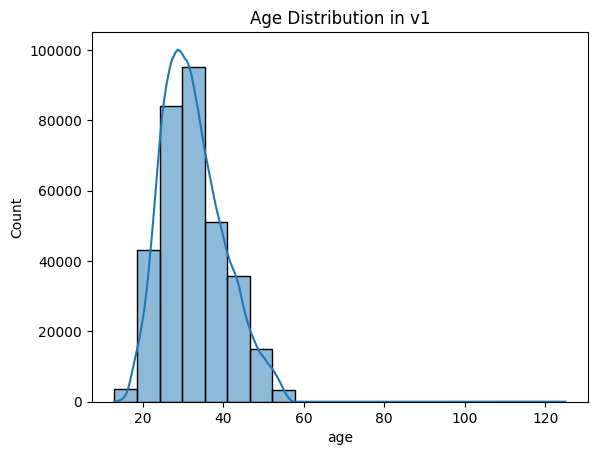

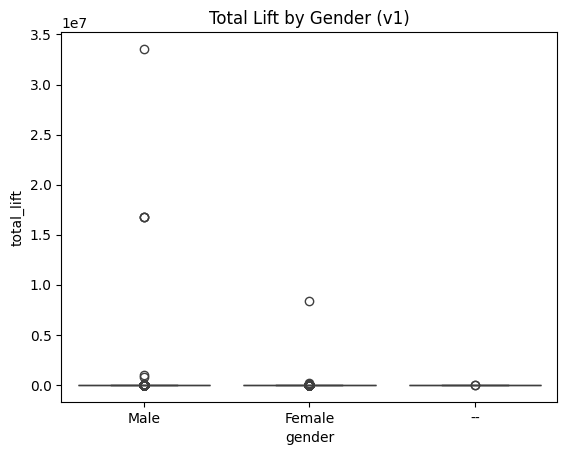

In [7]:
#5.

print(data_v1.isnull().sum())

print(data_v1.describe())

sns.histplot(data_v1['age'], bins=20, kde=True)
plt.title("Age Distribution in v1")
plt.show()

sns.boxplot(x="gender", y="total_lift", data=data_v1)
plt.title("Total Lift by Gender (v1)")
plt.show()

In [8]:
#6.

features = ["age", "height", "weight"]
target = "total_lift"

df_train = pd.concat([train_v1[features], train_v1[target]], axis=1).dropna()
X_train = df_train[features]
y_train = df_train[target]

df_test = pd.concat([test_v1[features], test_v1[target]], axis=1).dropna()
X_test = df_test[features]
y_test = df_test[target]

model_rf_v1 = RandomForestRegressor(random_state=42)
model_rf_v1.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
#7.

y_pred = model_rf_v1.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
r2 = r2_score(y_test, y_pred)

print("Model Performance on v1 Dataset (Random Forest)")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Model Performance on v1 Dataset (Random Forest)
MAE: 4606.74
RMSE: 317283.69
R²: -0.0162


#8.

As stated in the question, from here on out in the homework, I updated the dataset version to go to dataset v2 without changing anything else in the training code. No code was written for this question - I just switched my data reference from train_v1/test_v1 to train_v2/test_v2. From this point on, we work with train_v2 and test_v2.

                age        height        weight         candj        snatch  \
count  30832.000000  30832.000000  30832.000000  30832.000000  30832.000000   
mean      32.123670     68.870005    177.131033    205.426732    156.200895   
std        7.428352      3.776151     32.387674     58.829501     48.956132   
min       18.000000     52.000000      5.000000      1.000000      1.000000   
25%       27.000000     66.000000    155.000000    160.000000    120.000000   
50%       31.000000     69.000000    178.000000    205.000000    155.000000   
75%       37.000000     72.000000    197.000000    245.000000    190.000000   
max       56.000000     83.000000    474.000000    390.000000    386.000000   

           deadlift        backsq    total_lift  
count  30832.000000  30832.000000  30832.000000  
mean     362.082350    294.072003   1017.781980  
std       96.794676     85.266432    278.297178  
min        1.000000      1.000000      4.000000  
25%      287.000000    225.000000    8

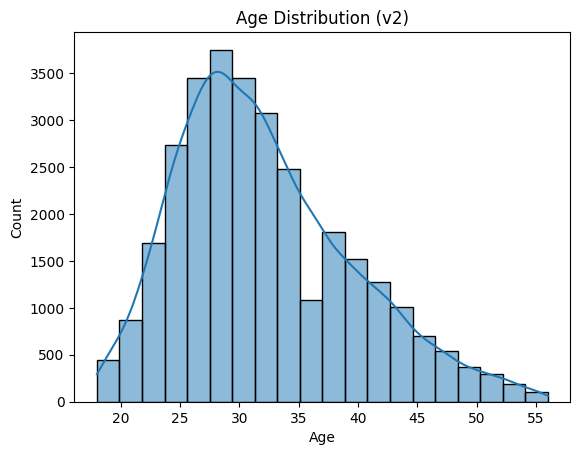

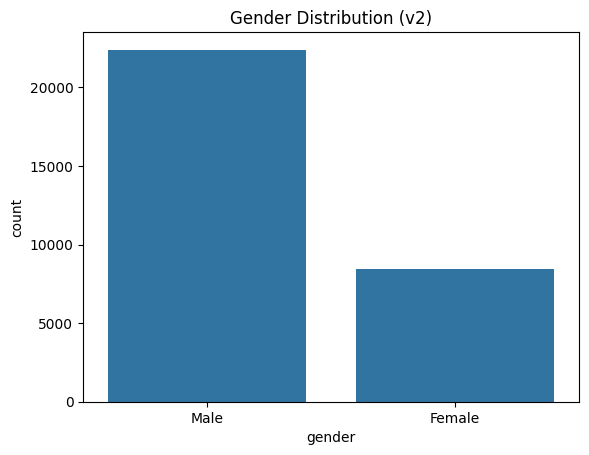

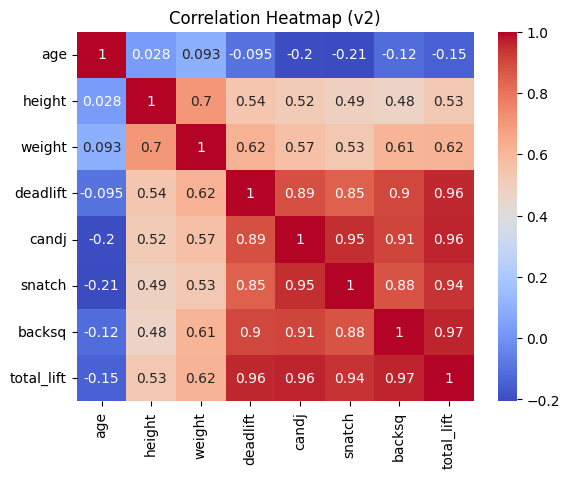

In [12]:
#9.

print(data_v2.describe())

sns.histplot(data_v2["age"], bins=20, kde=True)
plt.title("Age Distribution (v2)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

sns.countplot(x="gender", data=data_v2)
plt.title("Gender Distribution (v2)")
plt.show()

numeric_cols = ["age", "height", "weight", "deadlift", "candj", "snatch", "backsq", "total_lift"]
sns.heatmap(data_v2[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (v2)")
plt.show()

In [13]:
#10.

features = ["age", "height", "weight"]
target = "total_lift"

df_train_v2 = pd.concat([train_v2[features], train_v2[target]], axis=1).dropna()
X_train_v2 = df_train_v2[features]
y_train_v2 = df_train_v2[target]

df_test_v2 = pd.concat([test_v2[features], test_v2[target]], axis=1).dropna()
X_test_v2 = df_test_v2[features]
y_test_v2 = df_test_v2[target]

model_rf_v2 = RandomForestRegressor(random_state=42)
model_rf_v2.fit(X_train_v2, y_train_v2)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
#11.

y_pred_v2 = model_rf_v2.predict(X_test_v2)

mae_v2 = mean_absolute_error(y_test_v2, y_pred_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v2))  # fixed here
r2_v2 = r2_score(y_test_v2, y_pred_v2)

print("Model Performance on v2 Dataset (Random Forest)")
print(f"MAE: {mae_v2:.2f}")
print(f"RMSE: {rmse_v2:.2f}")
print(f"R²: {r2_v2:.4f}")


Model Performance on v2 Dataset (Random Forest)
MAE: 163.38
RMSE: 211.14
R²: 0.4301


#12.

The v1 model (Random Forest) shows poor performance, with MAE of 4606.74 and RMSE of 317283.69 and a negative R squared value of -0.0162. On the other hand, the v2 model (Random Forest) shows rather strong performance, with MAE of 163.38 and RMSE of 211.14 and a positive R squared value of 0.4301, which suggests that dataset v2, a cleaner and better engineered dataset, leads to better model accuracy.

In [32]:
#13.

features = ["age", "height", "weight"]
target = "total_lift"

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_v2[features])
X_test_scaled = scaler.transform(test_v2[features])
y_train = train_v2[target].values
y_test = test_v2[target].values

batch_size = 64
num_microbatches = 8
assert batch_size % num_microbatches == 0  

n_train = (len(X_train_scaled) // batch_size) * batch_size
X_train_trimmed = X_train_scaled[:n_train]
y_train_trimmed = y_train[:n_train]

val_size = batch_size
X_val = X_train_scaled[-val_size:]
y_val = y_train[-val_size:]

model_dp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_trimmed.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

optimizer = DPKerasAdamOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=1.1,
    num_microbatches=num_microbatches,
    learning_rate=0.001
)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

model_dp.compile(optimizer=optimizer, loss=loss_fn, metrics=['mae'])

model_dp.fit(
    X_train_trimmed,
    y_train_trimmed,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1
)



Epoch 1/20
385/385 [==============================] - 5s 7ms/step - loss: 1107085.6250 - mae: 1014.8538 - val_loss: 1059174.7500 - val_mae: 987.4540
Epoch 2/20
385/385 [==============================] - 2s 6ms/step - loss: 1080450.5000 - mae: 1002.1100 - val_loss: 1019193.5625 - val_mae: 967.5448
Epoch 3/20
385/385 [==============================] - 3s 7ms/step - loss: 1011560.7500 - mae: 968.8224 - val_loss: 931466.6250 - val_mae: 922.6910
Epoch 4/20
385/385 [==============================] - 2s 6ms/step - loss: 883925.6875 - mae: 903.9904 - val_loss: 784189.1250 - val_mae: 841.7094
Epoch 5/20
385/385 [==============================] - 2s 5ms/step - loss: 692613.8125 - mae: 795.7904 - val_loss: 581864.5000 - val_mae: 713.5512
Epoch 6/20
385/385 [==============================] - 2s 5ms/step - loss: 455605.0312 - mae: 633.5801 - val_loss: 353551.3125 - val_mae: 527.1418
Epoch 7/20
385/385 [==============================] - 2s 6ms/step - loss: 224775.3906 - mae: 418.6016 - val_loss: 160

In [37]:
#14.

n_train_examples = len(X_train_trimmed)
batch_size = 64
noise_multiplier = 1.1
epochs = 20
delta = 1e-5

eps, _ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
    n=n_train_examples,
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=epochs,
    delta=delta
)

print(f"DP ε after {epochs} epochs: {eps:.2f}")

DP ε after 20 epochs: 1.13


#15.

This question is answered in the submitted slide.